# Exploratory Analysis of the original dataset

## 1. Dataset and first adjustments

Import the necessary packages to begin loading the dataset and perform an initial exploration of the data.

In [1]:
import os
from sklearn.model_selection import train_test_split
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

- To work with Google Drive.

In [2]:
#from google.colab import files
# Using google colab
#from google.colab import drive
#drive.mount('/content/drive')

# Navegate to the folder containing the dataset
#%cd /content/drive/MyDrive/Datasets/Kaggle/chest_xray

- To work locally:

In [3]:
path_dir = "../../kaggle/pneumoniaDataset/chest_xray"

if os.path.exists(path_dir):
    print(f"The path {path_dir} is valid.")
else:
    print(f"The path {path_dir} is not valid. Please check the specified path.")


The path ../../kaggle/pneumoniaDataset/chest_xray is valid.


#### GPU with CUDA

In [4]:
torch.cuda.is_available()

True

In [5]:
# Check the device in use.
def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

In [6]:
device = set_device()
print(device)

cuda


## 2. Exploratory Data Analysis

This function is to analyze the number of elements in each set provided by the dataset.

In [7]:
def load_chest_xray_data( data_directory ):
    dirs = [ d for d in os.listdir( data_directory ) 
            if os.path.isdir( os.path.join( data_directory, d ) ) ]

    labels = []
    images = []
    for d in dirs:
        label_dir = os.path.join( data_directory, d )
        file_names = [ os.path.join( label_dir, f ) 
                        for f in os.listdir( label_dir )
                        if f.endswith(".jpeg") ]

        for f in file_names:
            images.append( skio.imread(f) )
            labels.append( str(d) )
    
    return images, labels

In [8]:
train_data_dir = os.path.join( path_dir, "train" )
test_data_dir = os.path.join( path_dir, "test" )

In [9]:
train_data_dir

'../../kaggle/pneumoniaDataset/chest_xray/train'

In [10]:
test_data_dir

'../../kaggle/pneumoniaDataset/chest_xray/test'

In [11]:
images, labels = load_chest_xray_data( train_data_dir )
images_test, labels_test = load_chest_xray_data( test_data_dir )

In [12]:
print( "TRAINING SET" )
print( "- Number of images: " + str( len(images) ))
print( "- Number of labels: " + str( len(labels) ))

print( "TEST SET" )
print( "- Number of images: " + str( len(images_test) ))
print( "- Number of labels: " + str( len(labels_test) ))

TRAINING SET
- Number of images: 5232
- Number of labels: 5232
TEST SET
- Number of images: 624
- Number of labels: 624


In [13]:
set(labels)

{'NORMAL', 'PNEUMONIA'}

Convert the list type to a numpy array.

In [14]:
# Training set
np_images = np.array(images, dtype=object)
np_labels = np.array(labels, dtype=object)
# Test set
np_images_test = np.array(images_test, dtype=object)
np_labels_test = np.array(labels_test, dtype=object)

Taking a specific image to verify that it has been loaded correctly.

In [15]:
np_images[15]

array([[0, 0, 0, ..., 2, 1, 1],
       [0, 0, 0, ..., 2, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
np_labels.ndim

1

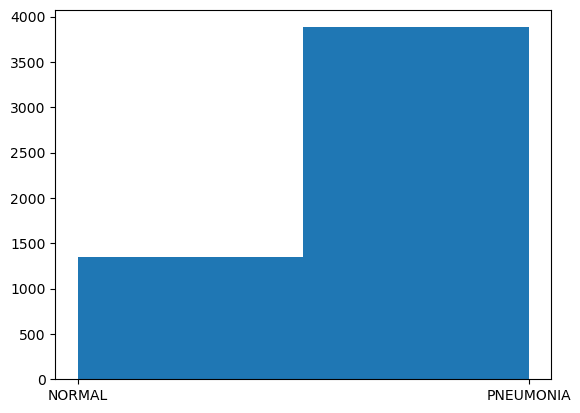

In [17]:
plt.hist(np_labels, len(set(np_labels)))
plt.show()

### Visual summary of the images

In [18]:
random_images = random.sample(range(0, len(np_labels)), 6)
random_images

[4275, 4331, 16, 4842, 214, 3976]

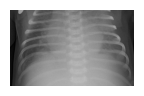

Shape:(470, 766, 3), min_color:0, max_color:193


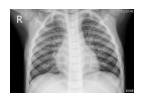

Shape:(1016, 1504), min_color:0, max_color:255


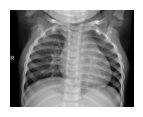

Shape:(1074, 1372), min_color:0, max_color:255


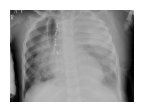

Shape:(968, 1304), min_color:0, max_color:255


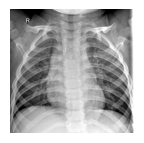

Shape:(1306, 1310), min_color:0, max_color:255


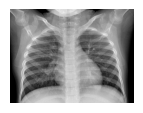

Shape:(1469, 1940), min_color:0, max_color:255


In [19]:
for i in range(len(random_images)):
    temp_image = np_images[random_images[i]]
    plt.subplot(2, 3, i+1)
    plt.axis("off")
    # cmap="gray" to view in grayscale. (If not, take the color scale)
    plt.imshow(temp_image, cmap="gray")
    plt.subplots_adjust(wspace = 0.5)
    plt.show()
    print("Shape:{0}, min_color:{1}, max_color:{2}".format(temp_image.shape,
                                               temp_image.min(),
                                               temp_image.max()))

The observations indicate that the images in the dataset vary in size and the difference between the minimum and maximum pixel values remains constant. Zero values represent black, and 255 represents white.

It is important to resize all images to the same dimensions for effective matrix operations.

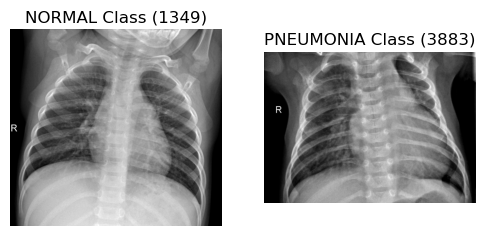

In [20]:
# Let's look at the class to which it belongs
unique_labels = set(labels)
plt.figure(figsize=(6,6))
i=1
for label in unique_labels:
    temp_image = np_images[labels.index(label)]
    plt.subplot(1,2, i)
    plt.axis("off")
    plt.title("{0} Class ({1})".format(label, labels.count(label)))
    i += 1
    plt.imshow(temp_image, cmap="gray")
plt.show()


The set of observations is initially structured into two files corresponding to a training set and a test set with 5232 and 624 observations, respectively. These files contain two categories that clearly differentiate between patients without pneumonia and patients with pneumonia.

Analyzing the dataset, we observe a clear data imbalance.

The initial exploration of the data allows us to see different features and issues to solve before using the data for training the model.

- Images of very diverse sizes.
- Some images are too big, and that might be unmanageable for the available hardware.
- The images are in grayscale.
- The distribution of the images is not uniform.
- The data is categorized into two groups ['Normal', 'Pneumonia'], but three possible classifications can be identified ['Normal', 'Bacteria', 'Virus'].
